In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
img_file = os.listdir('test_images/')
img_list = []
for i in range(0, len(img_file)):
    img_list.append(plt.imread('test_images/'+img_file[i]))

img_file

['solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg']

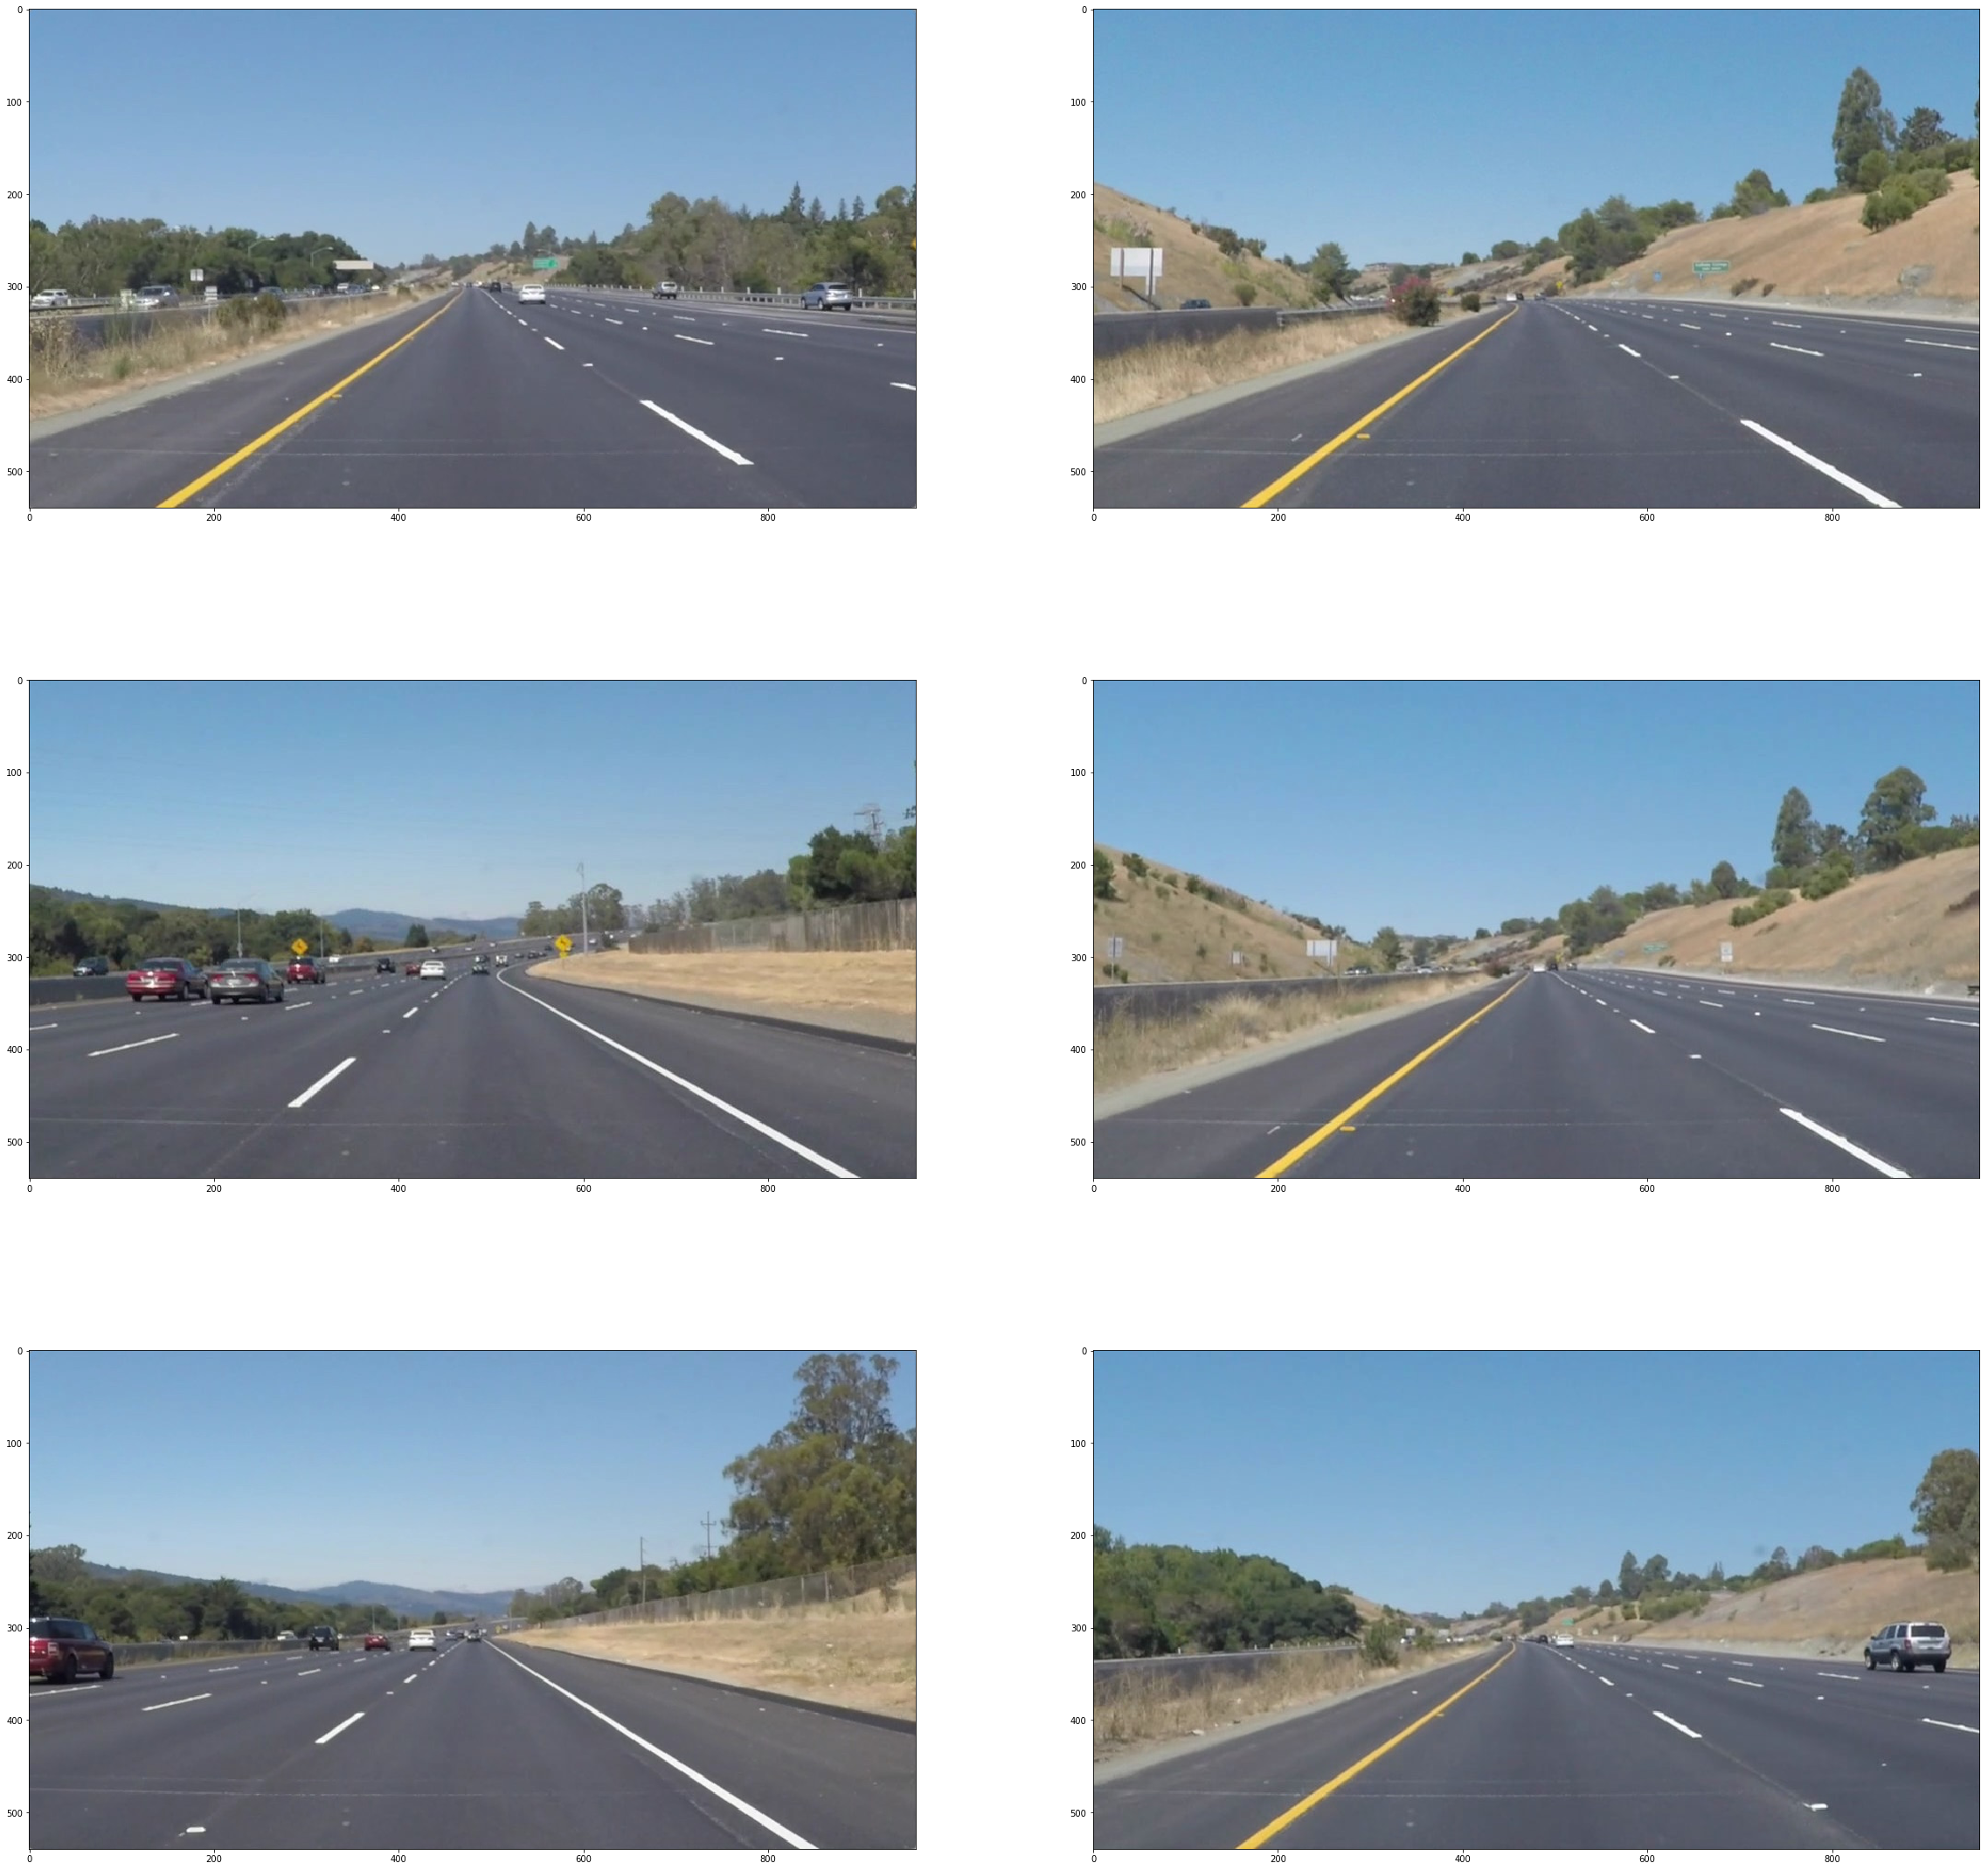

In [3]:
def display_img(img_list, cmap):
    plt.figure(figsize=(40,40))
    for i in range(0, len(img_list)):
        plt.subplot(3,2,i+1)
        plt.imshow(img_list[i],cmap)
        
display_img(img_list,None)

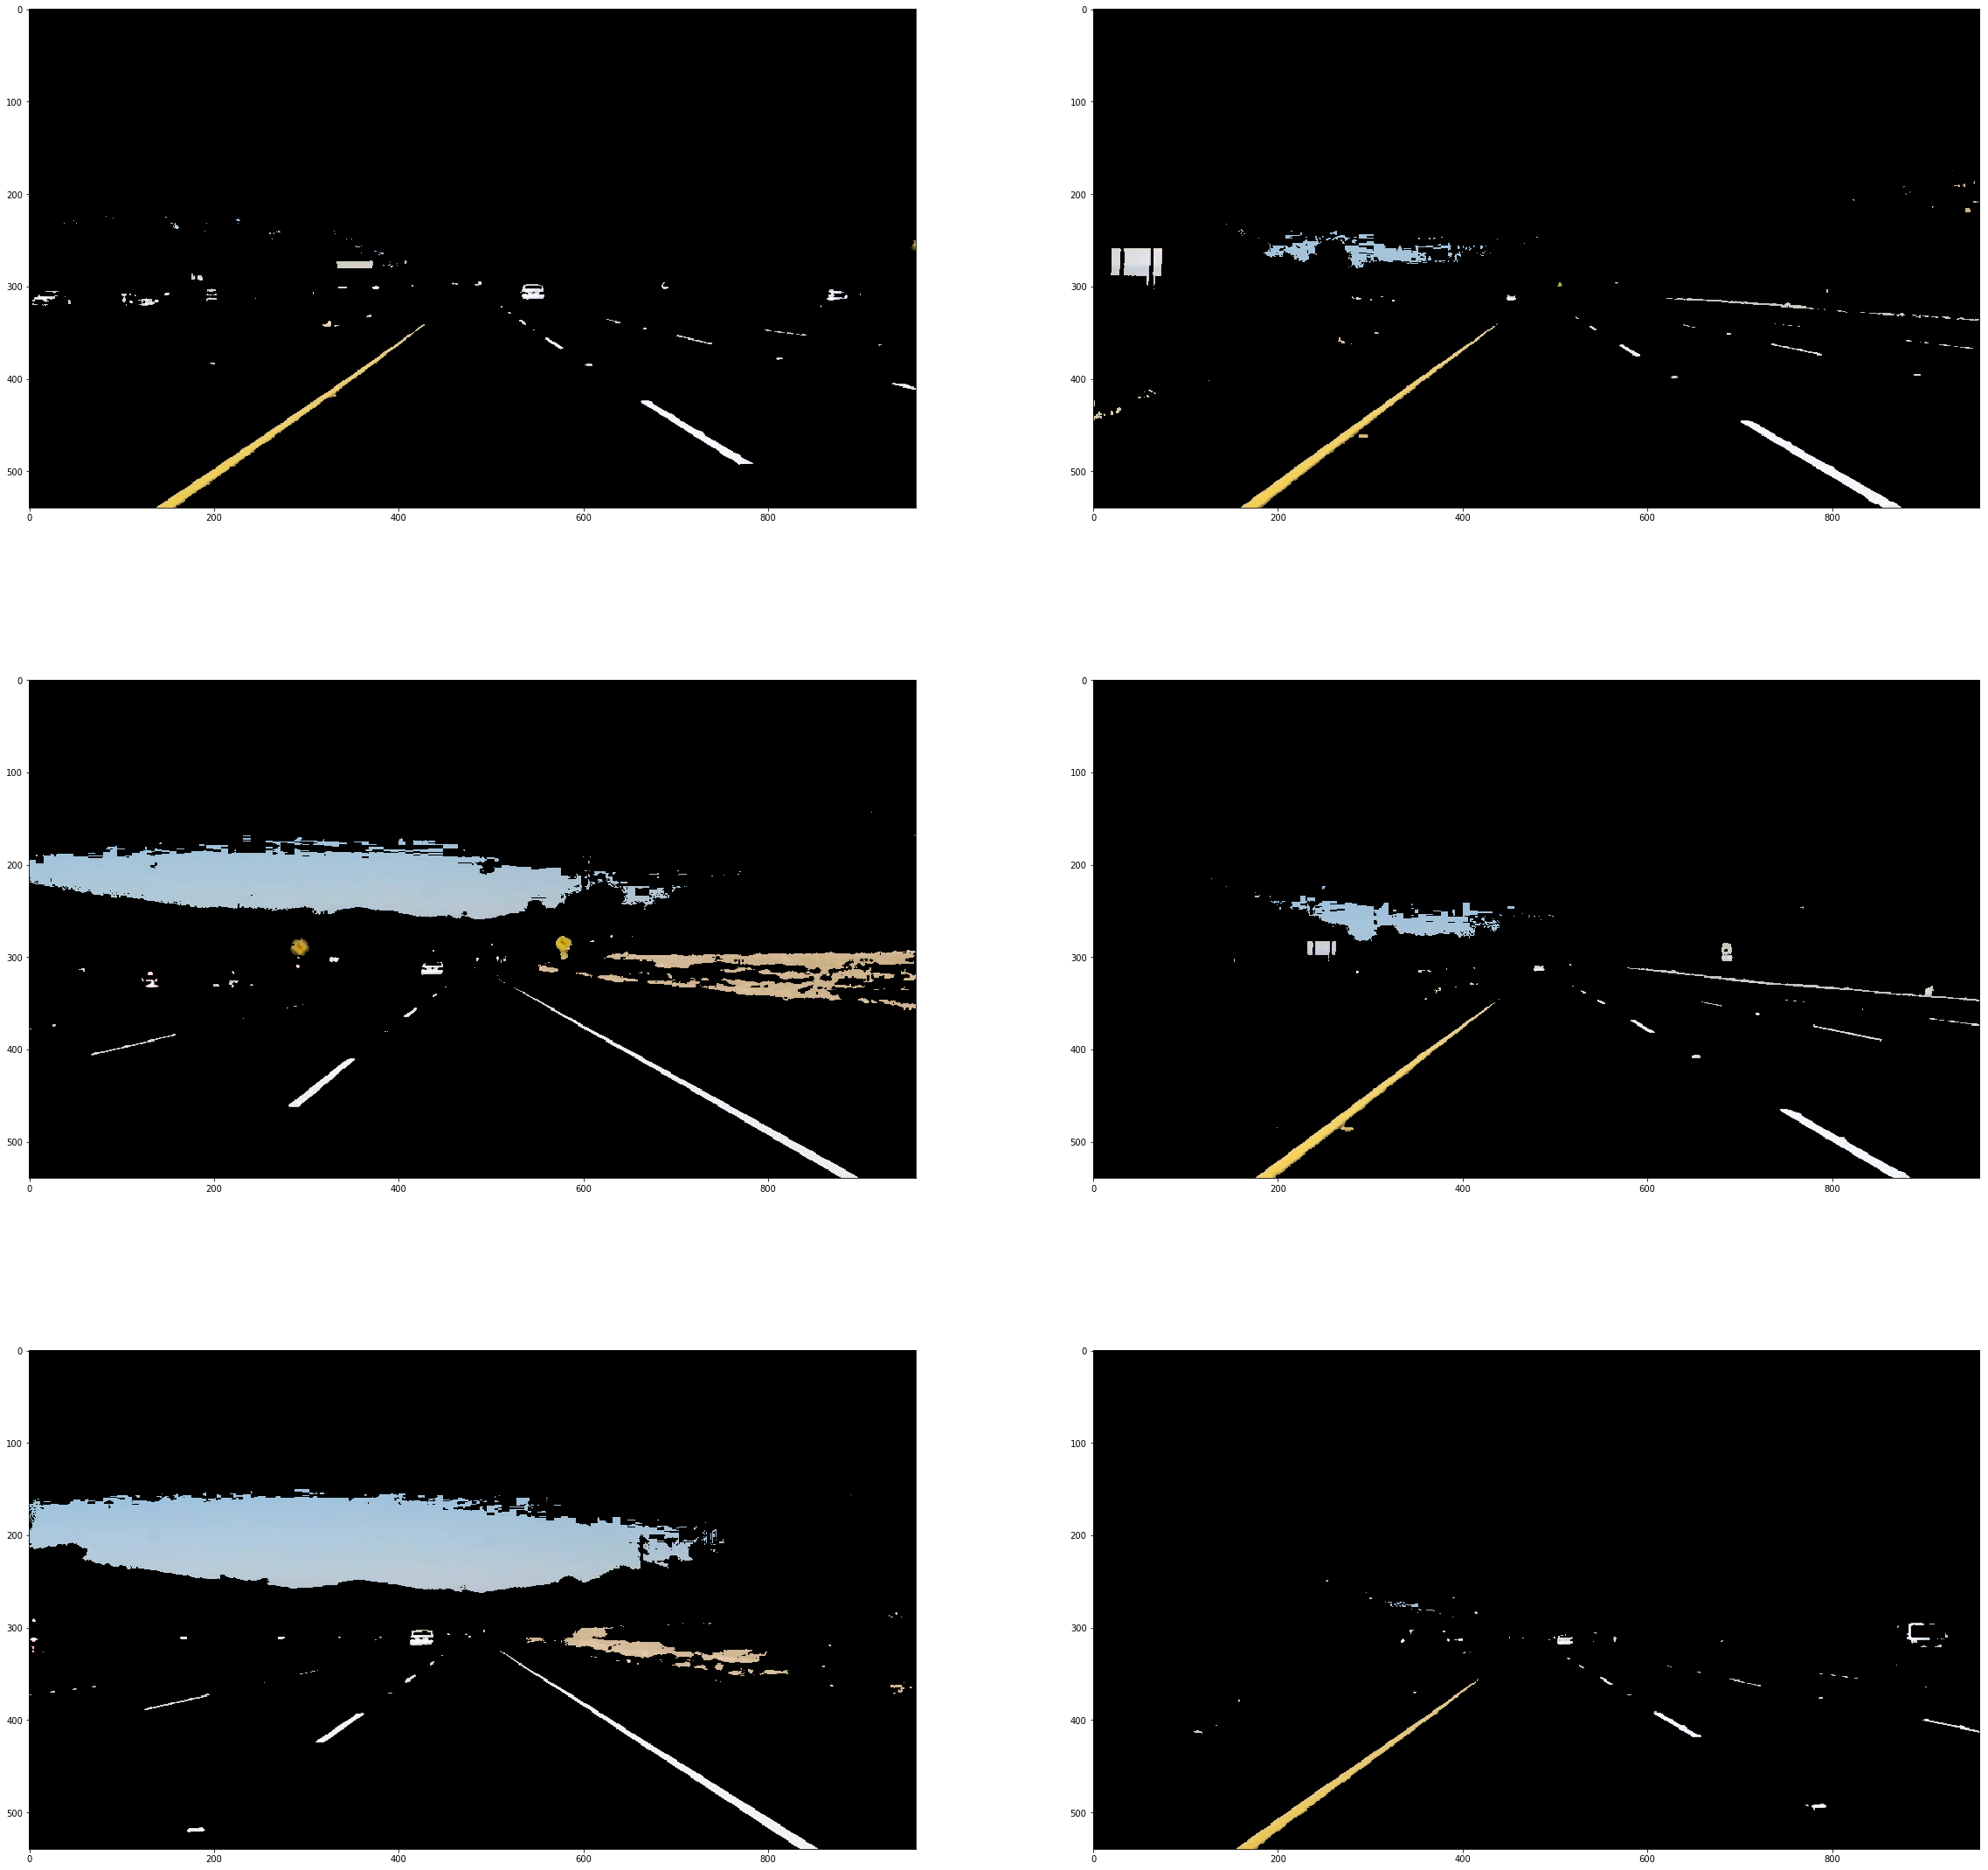

In [4]:
def masking(image):
    hls_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    white_lower = np.array([0,190,0])
    white_upper = np.array([255,255,255])
    yellow_lower = np.array([10,0,90])
    yellow_upper = np.array([40,255,255])

    white_mask = cv2.inRange(hls_img, white_lower, white_upper)
    yellow_mask = cv2.inRange(hls_img, yellow_lower, yellow_upper)

    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image,image, mask = mask)
    
    return masked_image

filtered_images = list(map(masking, img_list))
display_img(filtered_images,None)

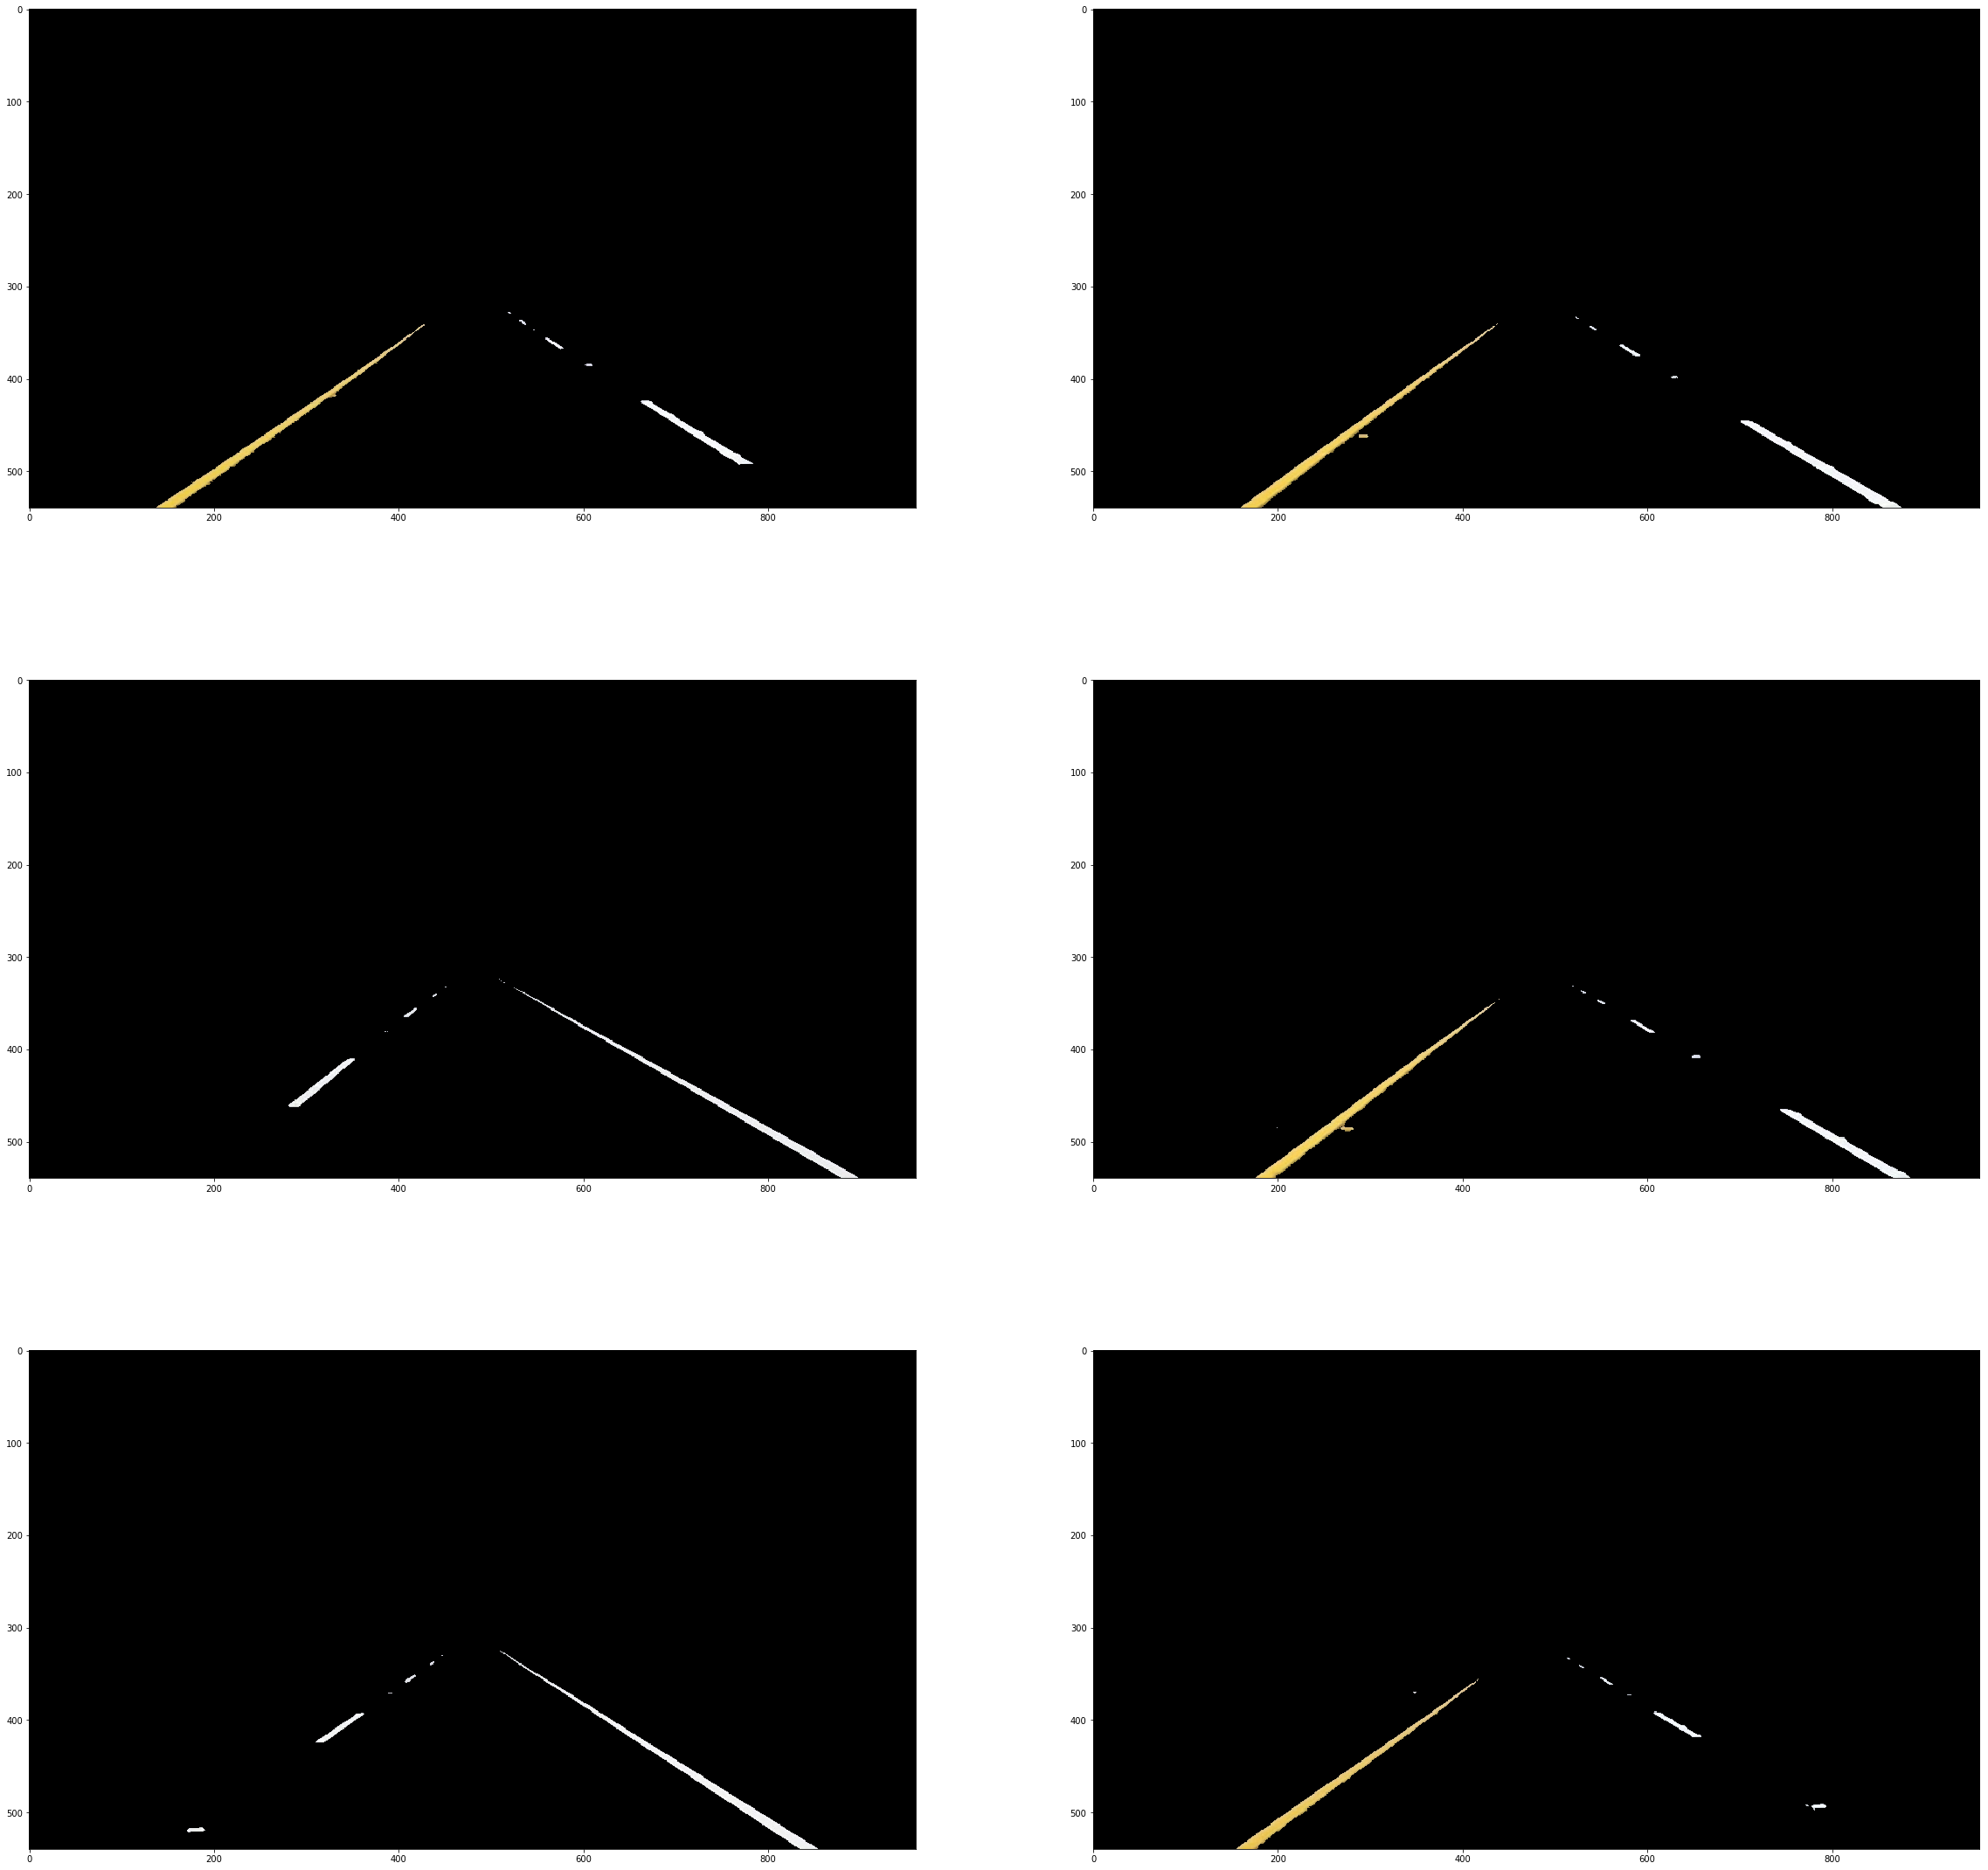

In [5]:
def roi(img):
    x = int(img.shape[1])
    y = int(img.shape[0])
    shape = np.array([[int(0), int(y)], [int(x), int(y)], [int(0.55*x), int(0.6*y)], [int(0.45*x), int(0.6*y)]])
    mask = np.zeros_like(img)
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    cv2.fillPoly(mask, np.int32([shape]), ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_images = list(map(roi, filtered_images))
display_img(roi_images,None)

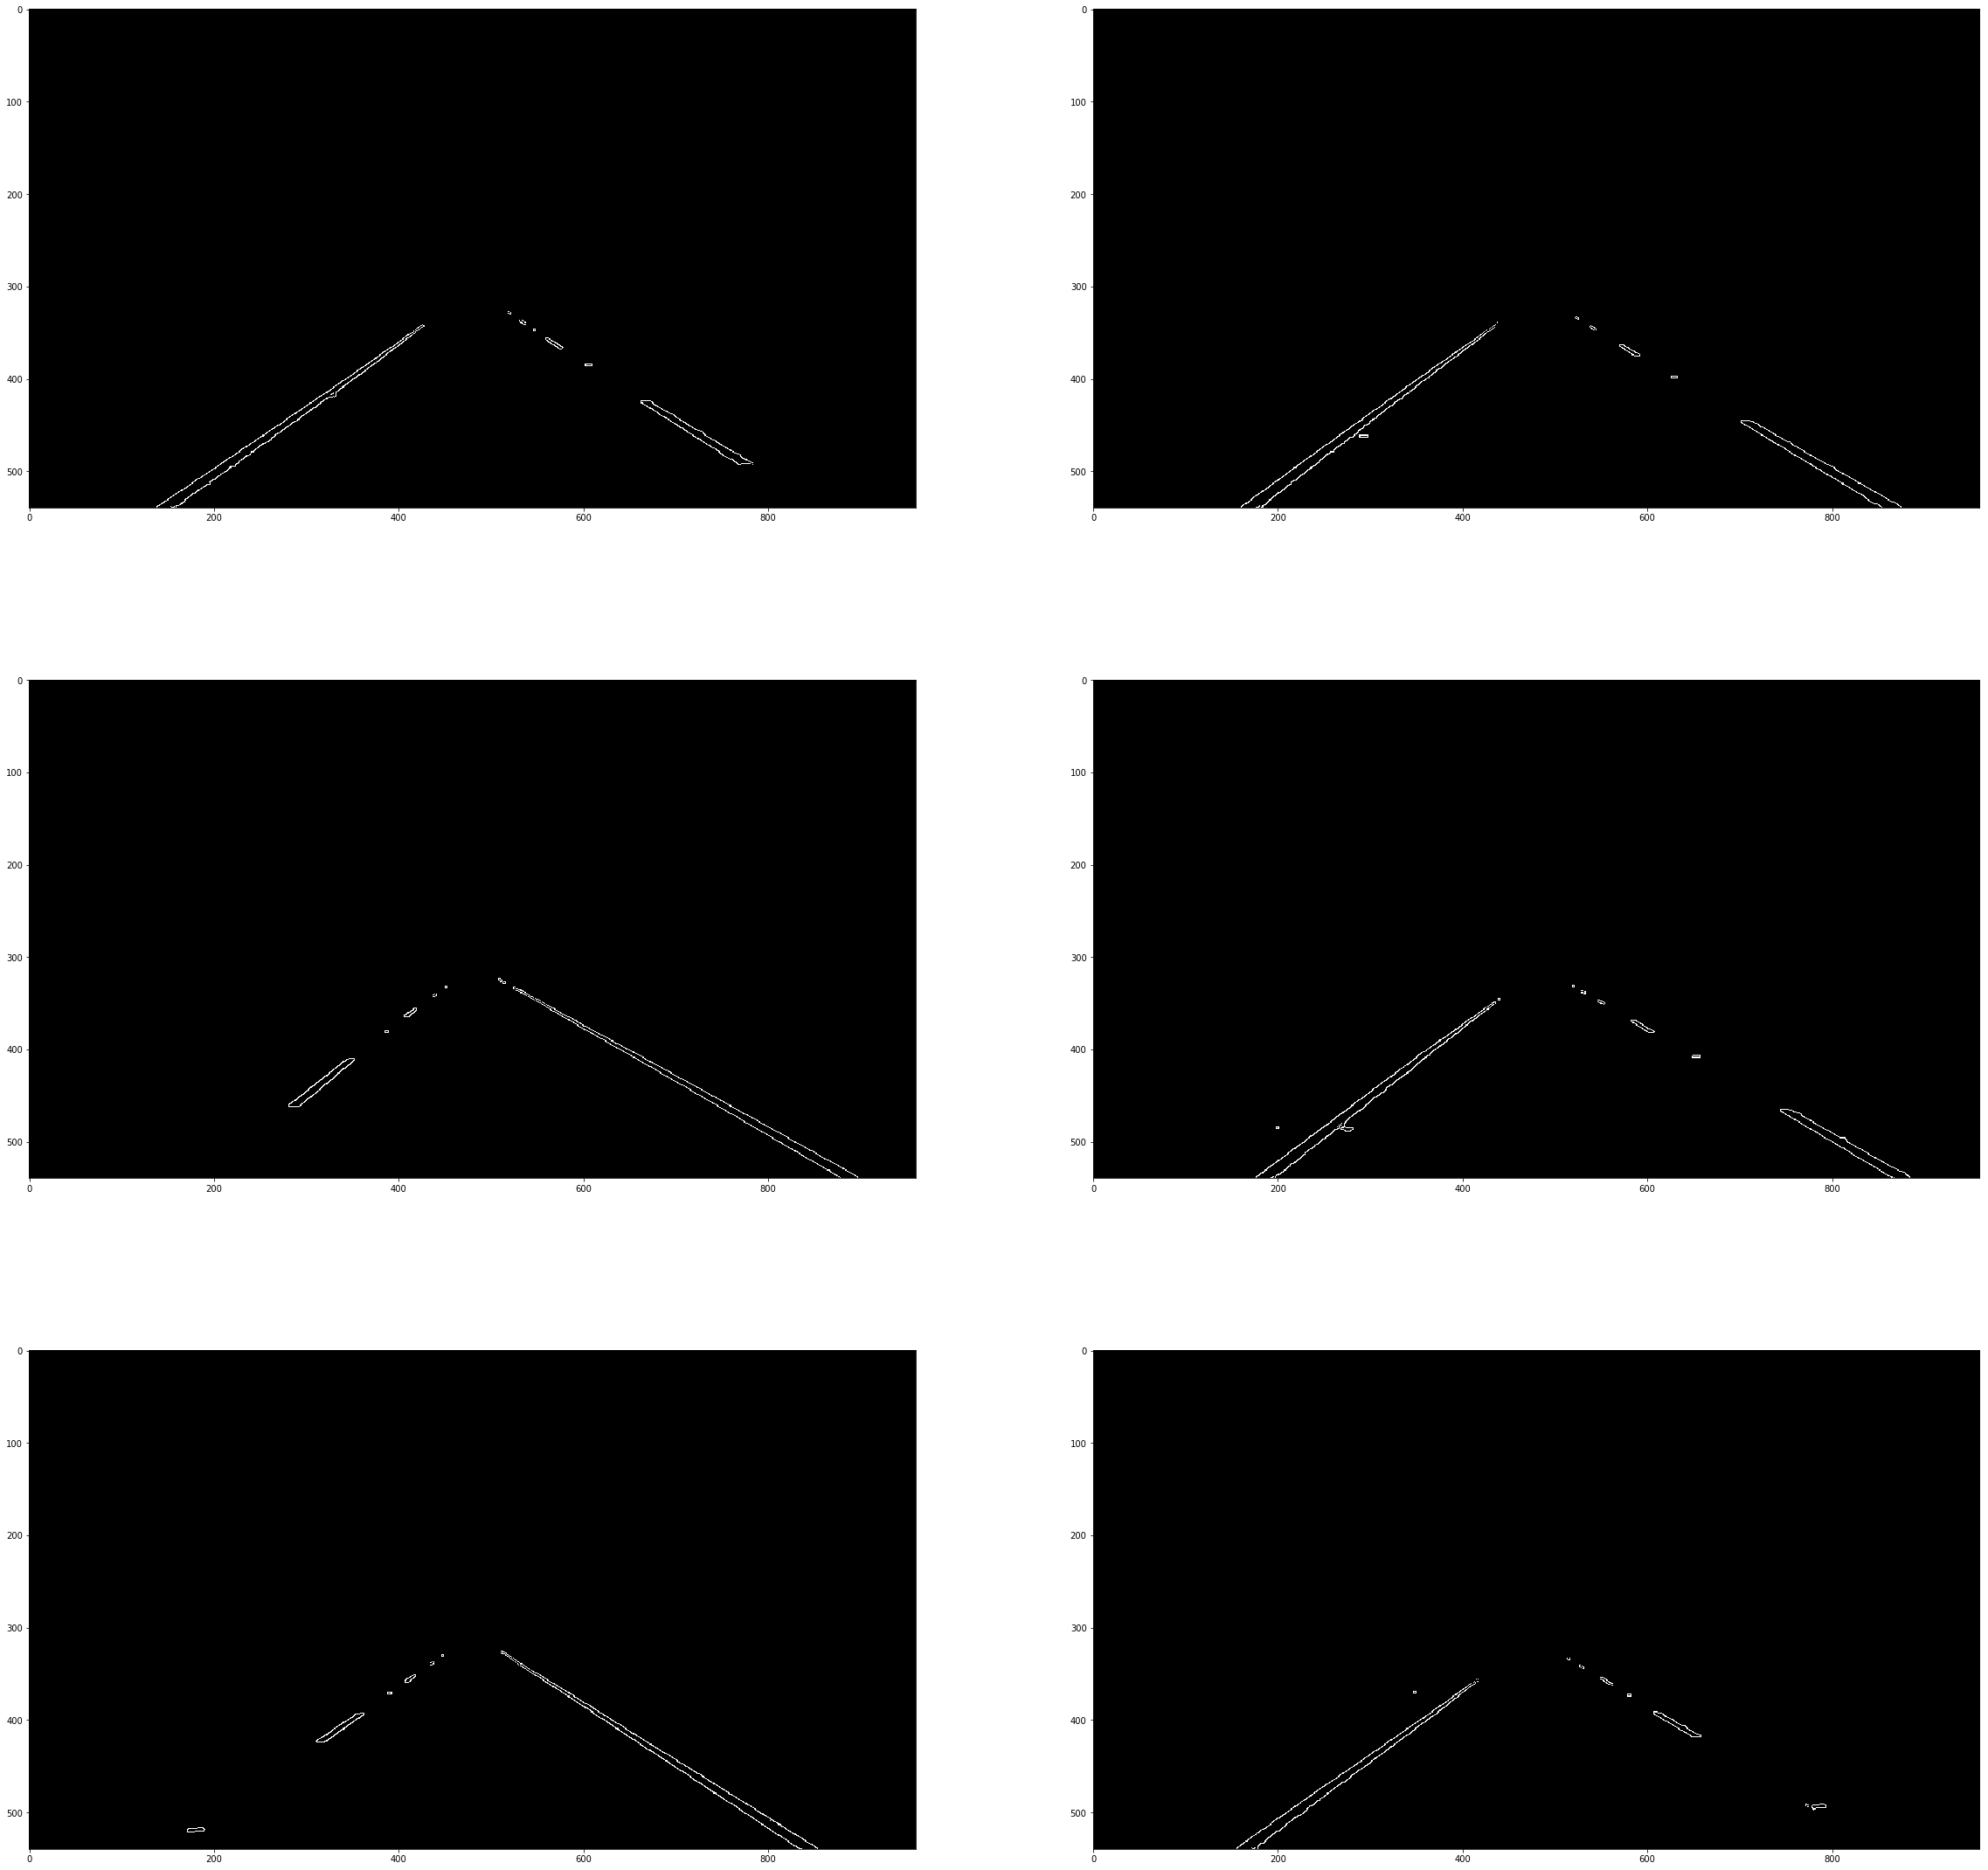

In [6]:
def canny_edge_detction(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    canny_image = cv2.Canny(gray_img, 50, 120)
    return canny_image

canny_images = list(map(canny_edge_detction, roi_images))
display_img(canny_images, cmap = 'gray')

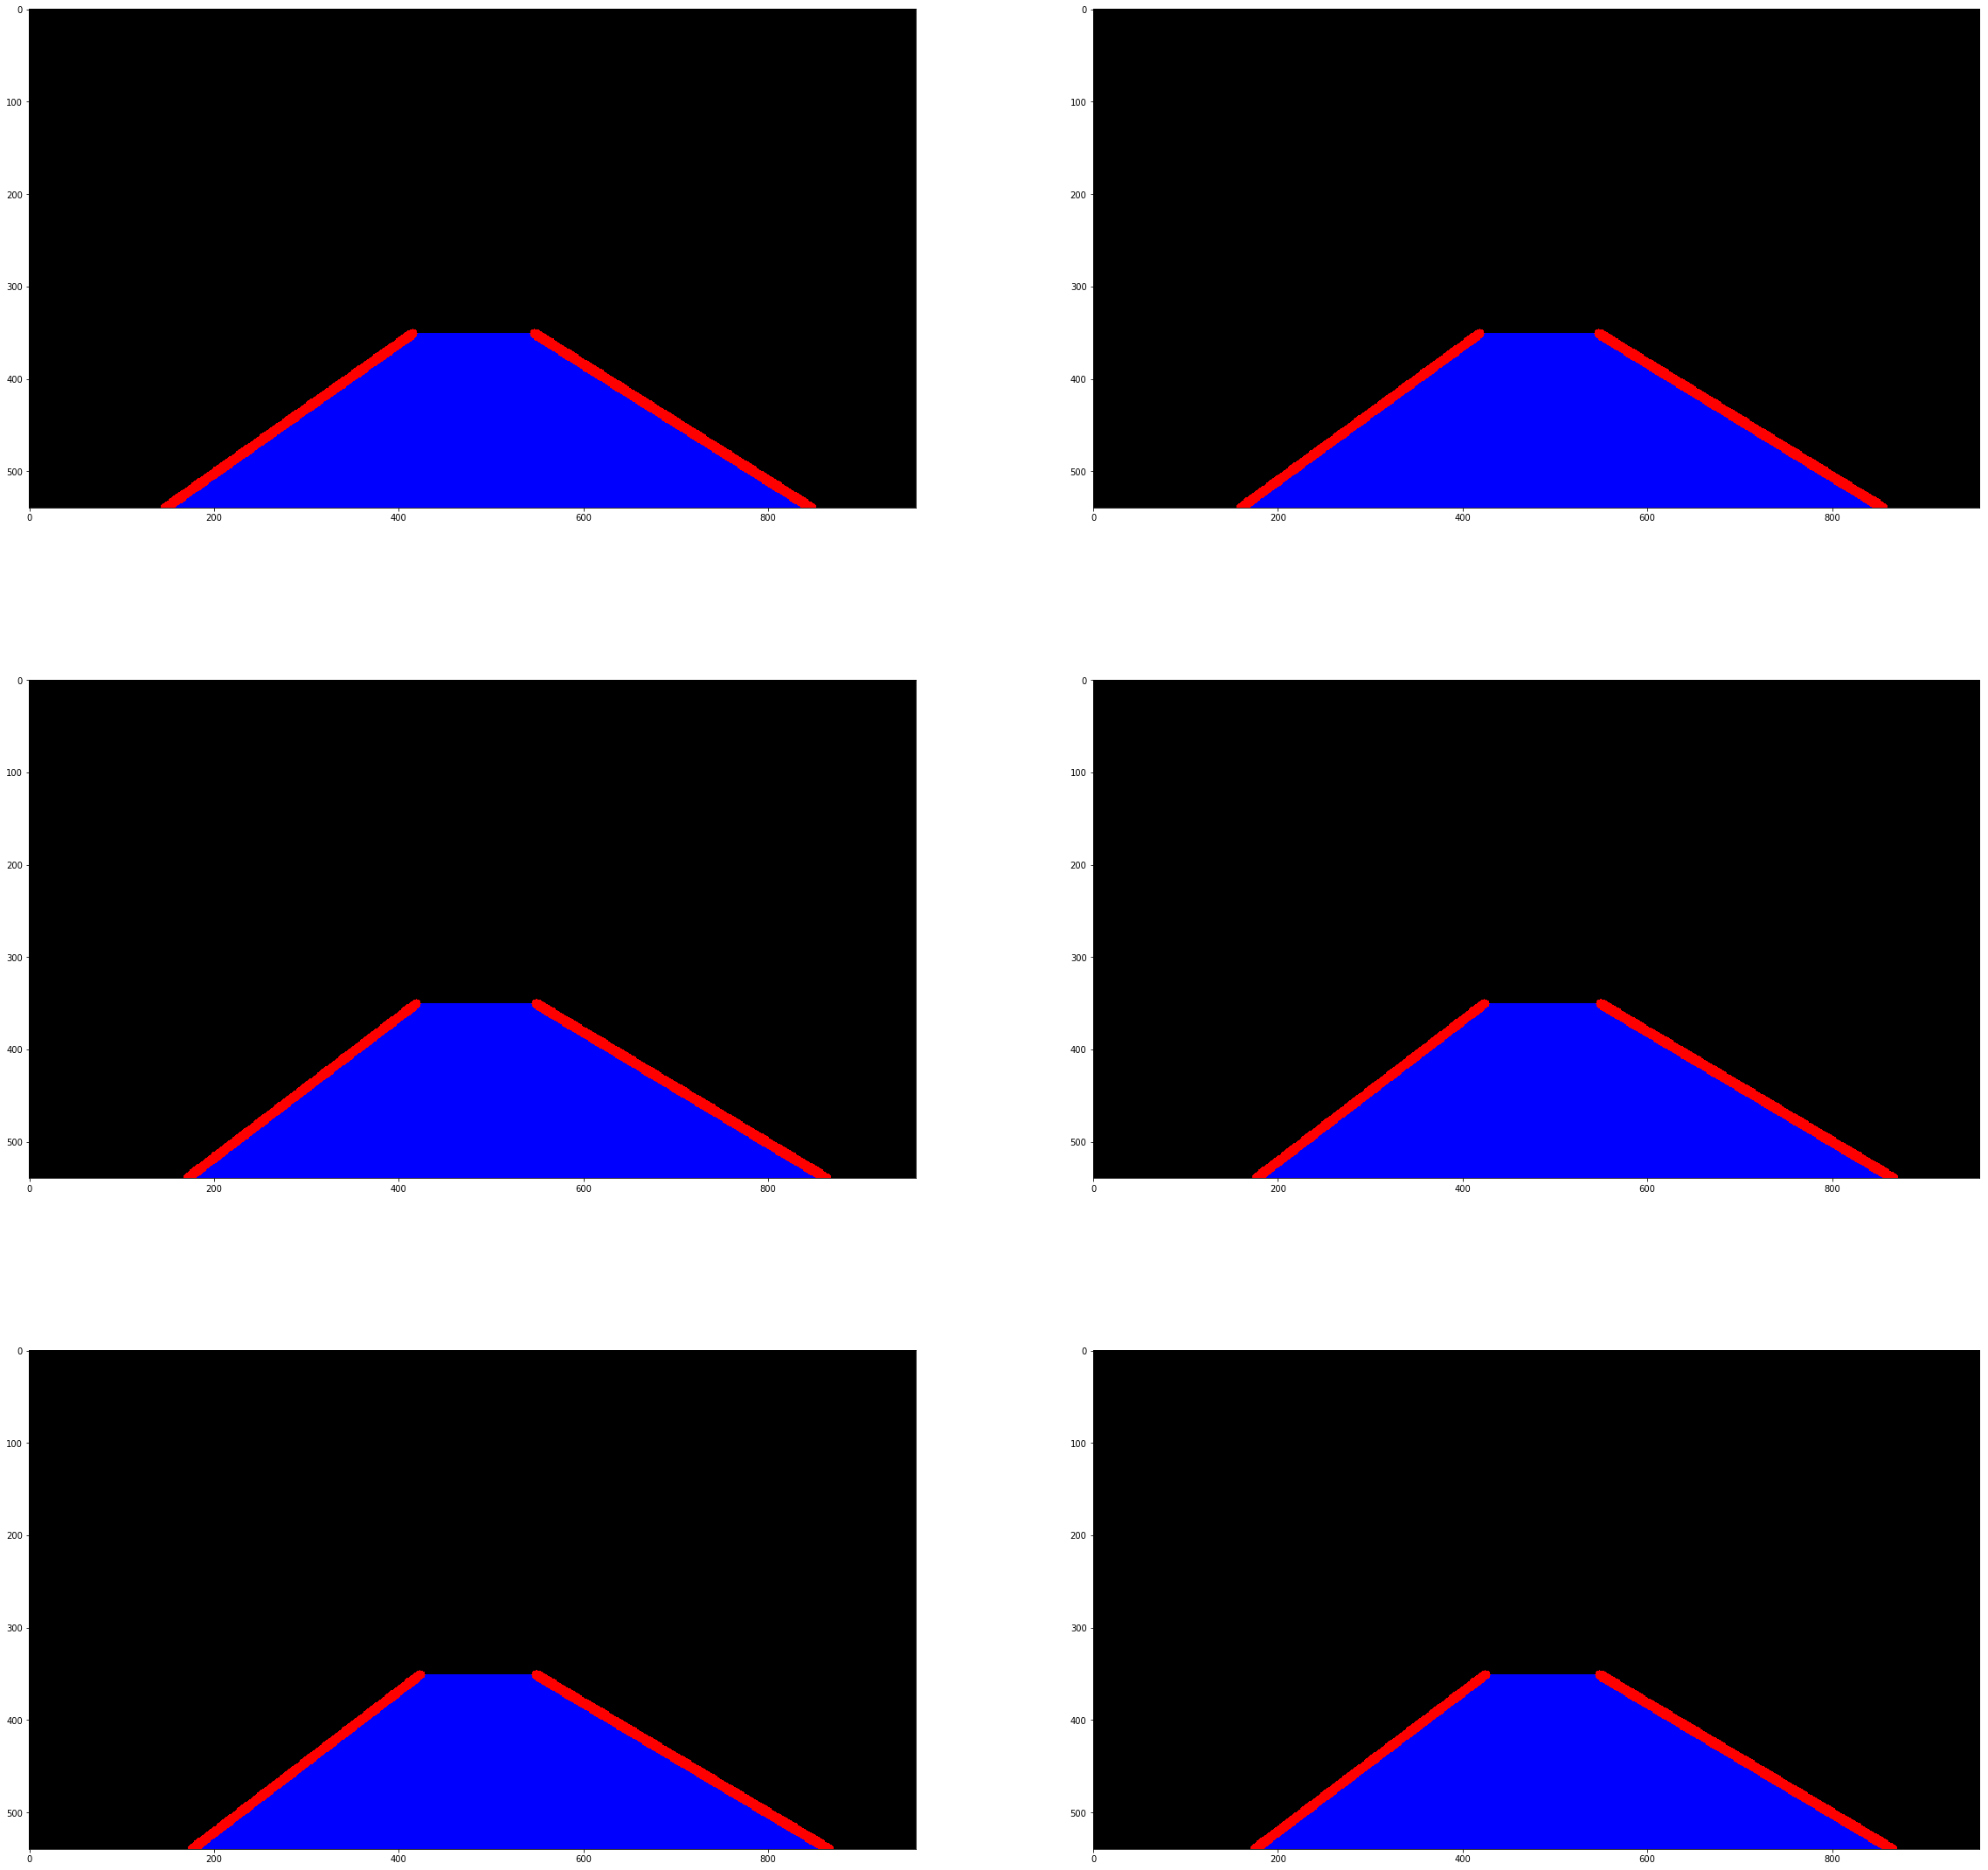

In [7]:
rightSlope, leftSlope, rightIntercept, leftIntercept = [],[],[],[]
def draw_lines(img, lines, thickness=5):
    global rightSlope, leftSlope, rightIntercept, leftIntercept

 
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1-y2)/(x1-x2)
            if slope > 0.3:
                if x1 > 500 :
                    yintercept = y2 - (slope*x2)                    
                    rightSlope.append(slope)
                    rightIntercept.append(yintercept)
                else: None                
            elif slope < -0.3:
                if x1 < 600:
                    yintercept = y2 - (slope*x2)                    
                    leftSlope.append(slope)
                    leftIntercept.append(yintercept)    
                    
    leftavgSlope = np.mean(leftSlope[-30:])
    leftavgIntercept = np.mean(leftIntercept[-30:])
    
    rightavgSlope = np.mean(rightSlope[-30:])
    rightavgIntercept = np.mean(rightIntercept[-30:])
    
    try:
        left_line_x1 = int((0.65*img.shape[0] - leftavgIntercept)/leftavgSlope)
        left_line_x2 = int((img.shape[0] - leftavgIntercept)/leftavgSlope)
    
        right_line_x1 = int((0.65*img.shape[0] - rightavgIntercept)/rightavgSlope)
        right_line_x2 = int((img.shape[0] - rightavgIntercept)/rightavgSlope)

        pts = np.array([[left_line_x1, int(0.65*img.shape[0])],[left_line_x2, int(img.shape[0])],[right_line_x2, int(img.shape[0])],[right_line_x1, int(0.65*img.shape[0])]], np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img,[pts],(0,0,255))      
        
        
        cv2.line(img, (left_line_x1, int(0.65*img.shape[0])), (left_line_x2, int(img.shape[0])), [255,0,0], 10)
        cv2.line(img, (right_line_x1, int(0.65*img.shape[0])), (right_line_x2, int(img.shape[0])),[255,0,0], 10)
    except ValueError:
        pass
    
    
    
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def linedetect(img):
    return hough_lines(img, 1, np.pi/180, 10, 20, 100)

hough_img = list(map(linedetect, canny_images))
display_img(hough_img,None)

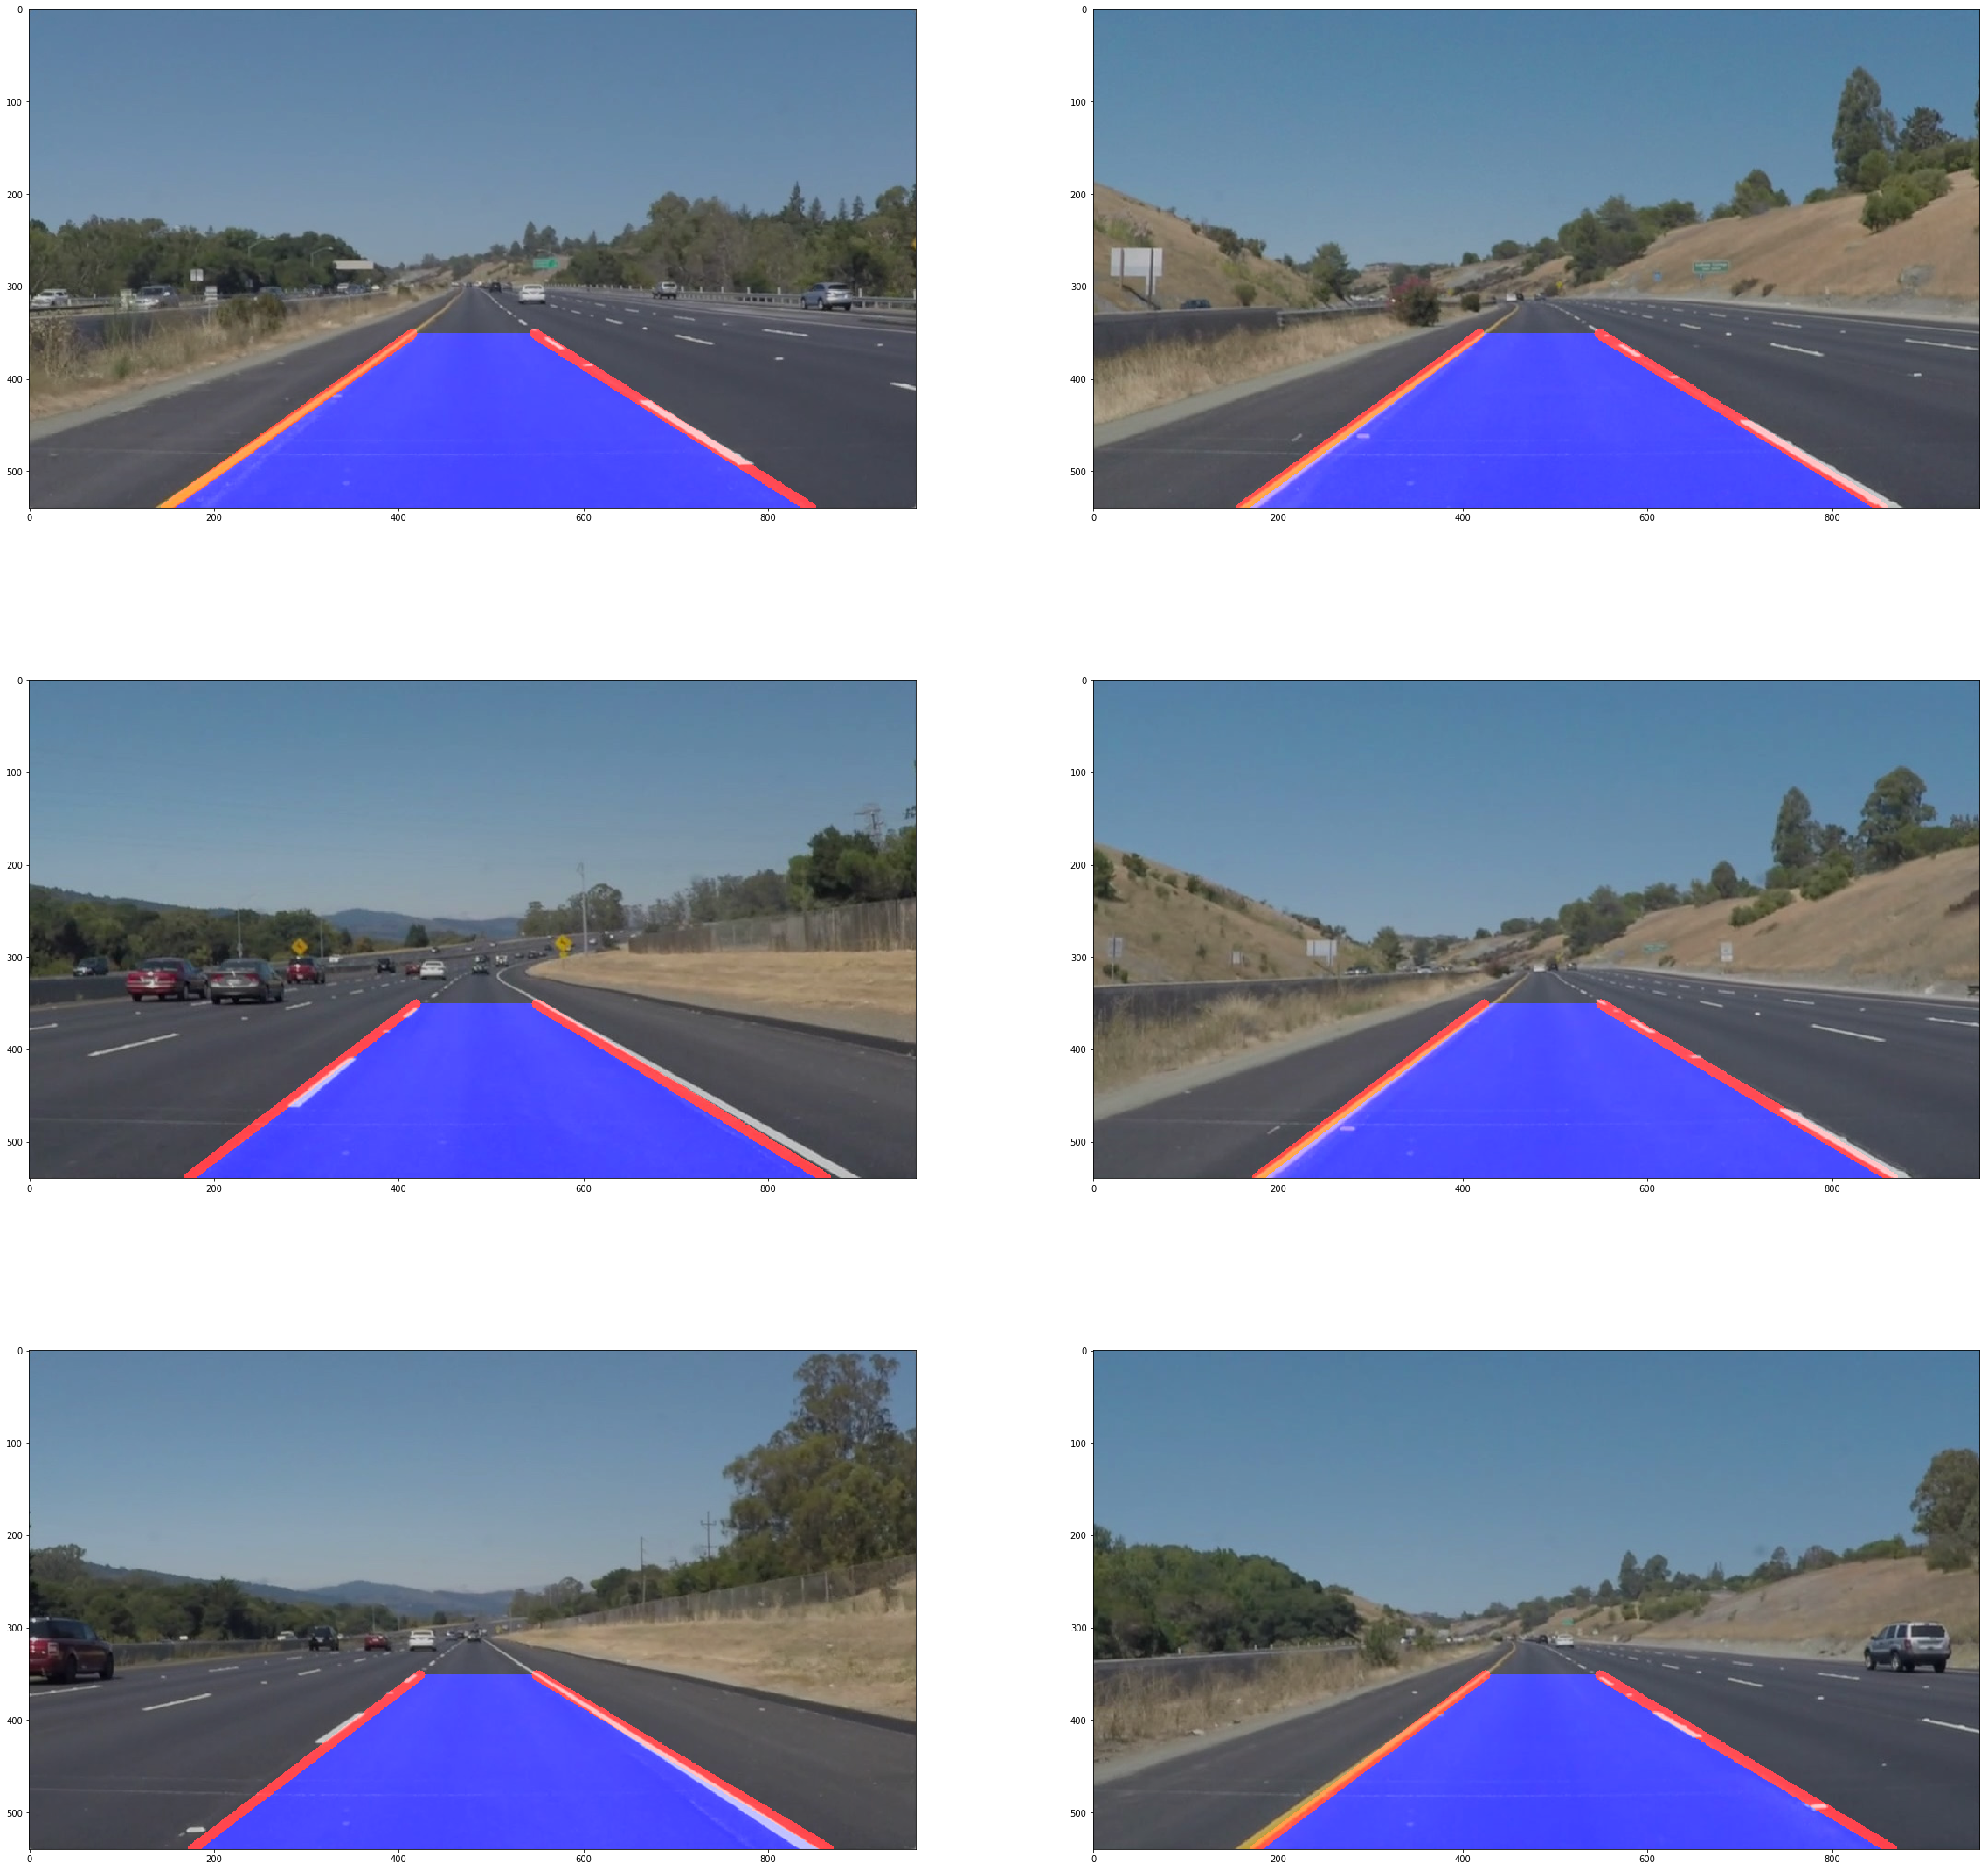

In [8]:
def weightSum(input_set):
    img = list(input_set)
    return cv2.addWeighted(img[0], 1, img[1], 0.8, 0)

result_img = list(map(weightSum, zip(hough_img, img_list)))
display_img(result_img, None)

In [9]:
video_list = []
cap = cv2.VideoCapture('test_videos/solidYellowLeft.mp4')
video_list.append(cap)
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        break
    filtered_frame = masking(frame)
    roi_frame = roi(filtered_frame)
    canny_frame = canny_edge_detction(roi_frame)
    hough_frame = linedetect(canny_frame)
    result_frame = cv2.addWeighted(hough_frame,1,frame,0.8,0)
    cv2.imshow('original_video',frame)
    cv2.imshow('frame1',result_frame)
    if cv2.waitKey(1) == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()
        